# **GALERKIN in TIME**

## **Install**

### Firedrake

In [2]:
try:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh"
    !bash "/tmp/firedrake-install.sh"
    from firedrake import *  # noqa: F401
except:
    from firedrake import *  # noqa: F401

--2025-11-03 13:41:43--  https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4767 (4.7K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.66K  --.-KB/s    in 0s      

2025-11-03 13:41:43 (47.4 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4767/4767]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/a082

### Irksome

In [4]:
try:
    !python3 -m pip install --no-dependencies git+https://github.com/firedrakeproject/Irksome.git
    from irksome import *  # noqa: F401
except:
    from irksome import *  # noqa: F401

  Cloning https://github.com/firedrakeproject/Irksome.git to /tmp/pip-req-build-ka7u_140
  Running command git clone --filter=blob:none --quiet https://github.com/firedrakeproject/Irksome.git /tmp/pip-req-build-ka7u_140
  Resolved https://github.com/firedrakeproject/Irksome.git to commit 88c48cbec74cf355ccac3d9d08c65f9a9fad8b14
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for IRKsome: filename=irksome-0.0.1-py3-none-any.whl size=60606 sha256=9c21e84b87d84799b5014077eb87b448310dfbc629b04ec554c04c046da5bb7a
  Stored in directory: /tmp/pip-ephem-wheel-cache-5pyxzz89/wheels/d2/9a/b0/fa0519647bfe73fa482134dfb68f1e94bba6822b7c0db00983
Successfully built IRKsome


### Other

In [30]:
import math
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from typing import Dict, List, Union
from scipy import special
from mpl_toolkits.mplot3d import Axes3D

## **General functions**

### Time integrals

In [5]:
class DxTime:
    def __init__(self, time_deg, space_deg=None):
        self.quad_rule = TimeQuadratureLabel(time_deg)
        self.dx_space = dx(space_deg) if space_deg is not None else dx

    def __rmul__(self, ufl_expr):
        return self.quad_rule(ufl_expr * self.dx_space)

def dx_time(time_deg, space_deg=None):
    return DxTime(time_deg=time_deg, space_deg=space_deg)

### Nonlinear Schrödinger: Energy

In [91]:
def nls(
    N:          int = 200,
    deg:        int = 1,
    time_deg:   int = 1,
    Nt:         int = 400,
    dt:         Union[int, float] = 1.0e-3,
    L:          Union[int, float] = 20.0,
    speed:      Union[int, float] = 0.5,
    eta:        Union[int, float] = 1.0,
    x0:         Union[int, float] = 10.0,
    output_dir: str = "output/nls/",
    write_qois: bool = False,
    write_vtk:  bool = False,
) -> Dict[str, List[float]]:
    """
    1D nonlinear Schrödinger equation with standard continuous Petrov-Galerkin (energy-conserving).

    Returns
    - Dictionary: {"time": [...], "mass": [...], "momentum": [...], "energy": [...]}
    """

    # Ensure output directory exists
    out_path = Path(output_dir)
    out_path.mkdir(parents=True, exist_ok=True)

    # Convert parameters to UFL objects
    dt_c = Constant(dt)
    speed_c = Constant(speed)
    eta_c = Constant(eta)
    x0_c = Constant(x0)

    # Mesh and coordinates (interval)
    mesh = IntervalMesh(N, 0.0, L)
    x, = SpatialCoordinate(mesh)

    # Function spaces and functions
    V = FunctionSpace(mesh, "CG", deg)
    Z = V * V
    psi = Function(Z, name="state")
    a, b = split(psi)
    a_out, b_out = psi.subfunctions
    v, w = TestFunctions(Z)

    # Initial condition (soliton)
    amp = eta_c / cosh(eta_c * (x - x0_c))
    phase = speed_c * x
    bcs = [DirichletBC(Z.sub(i), 0.0, "on_boundary") for i in (0, 1)]
    a_ic = amp * cos(phase); b_ic = amp * sin(phase)
    psi.project(as_vector([a_ic, b_ic]), bcs=bcs)

    # Continuous Petrov-Galerkin residual
    dx_time_2     = dx_time(time_deg=2*time_deg-2)
    dx_time_2plus = dx_time(time_deg=2*time_deg-1)
    dx_time_4plus = dx_time(time_deg=4*time_deg-1)
    amp_squared = a**2 + b**2
    F = (
        (  # Real
            inner(Dt(b), v) * dx_time_2
          + 0.5 * inner(grad(a), grad(v)) * dx_time_2plus
          + inner(amp_squared * a, v) * dx_time_4plus
        )
      + (  # Imaginary
          - inner(Dt(a), w) * dx_time_2
          + 0.5 * inner(grad(b), grad(w)) * dx_time_2plus
          + inner(amp_squared * b, w) * dx_time_4plus
        )
    )

    # Quantities of interest
    M = amp_squared * dx
    P = (a * b.dx(0) - b * a.dx(0)) * dx
    E = 0.5 * (inner(grad(a), grad(a)) + inner(grad(b), grad(b)) + amp_squared**2) * dx

    # Time stepper
    t = Constant(0.0)
    sp = {
        # "snes_rtol": 1.0e-12,
        # "snes_atol": 1.0e-14,
        # "snes_max_it": 50,
        # # "snes_converged_reason": None,
        # # "snes_linesearch_monitor": None,
        # # "snes_monitor": None,
        # "ksp_type": "gmres",
        # "ksp_rtol": 1.0e-12,
        # "ksp_atol": 1.0e-14,
        # "pc_type": "lu",
        # "pc_factor_mat_solver_type": "mumps",
    }
    stepper = GalerkinTimeStepper(F, time_deg, t, dt_c, psi, bcs=bcs, solver_parameters=sp)

    # Set up outputs
    t_arr: List[float] = []
    M_arr: List[float] = []
    P_arr: List[float] = []
    E_arr: List[float] = []
    if write_qois:
        qoi_path = out_path / "qois.csv"
        with qoi_path.open("w", encoding="utf-8") as f:
            f.write("time,mass,momentum,energy\n")

    if write_vtk:
        vtk = VTKFile(str(out_path / "psi_mag.pvd"))
        a_out.rename("Real part (Re(psi))"); b_out.rename("Imaginary part (Im(psi))")
        vtk.write(a_out, b_out, time=float(t))

    def record_and_log():
        t_out = float(t)
        M_out = float(assemble(M))
        P_out = float(assemble(P))
        E_out = float(assemble(E))
        print(BLUE % f"Time (t): {t_out}")
        print(GREEN % f"\tMass:     {M_out}")
        print(GREEN % f"\tMomentum: {P_out}")
        print(GREEN % f"\tEnergy:   {E_out}")
        t_arr.append(t_out)
        M_arr.append(M_out)
        P_arr.append(P_out)
        E_arr.append(E_out)
        if write_qois:
            with qoi_path.open("a", encoding="utf-8") as f:
                f.write(f"{t_out},{M_out},{P_out},{E_out}\n")

    record_and_log()

    # Time loop
    for _ in range(Nt):
        stepper.advance()
        t.assign(float(t) + float(dt_c))
        if write_vtk: vtk.write(a_out, b_out, time=float(t))
        record_and_log()

    return {"psi": psi, "time": t_arr, "mass": M_arr, "momentum": P_arr, "energy": E_arr}

In [92]:
N = 2**9
time_deg = 1
T = 2**3
L = 2**5
dt = 2**0
nls_out = nls(N=N, deg=1, time_deg=1, Nt=round(T/dt), dt=dt, L=L, speed=N/L/1.61803398875, eta=1.0, x0=L/2)

Time (t): 0.0
	Mass:     1.9995463717983486
	Momentum: 19.755161362690693
	Energy:   101.97607769825943
Time (t): 1.0
	Mass:     1.9995464076887586
	Momentum: 19.75516244904808
	Energy:   101.97607773003504
Time (t): 2.0
	Mass:     1.999546514007134
	Momentum: 19.755165693719384
	Energy:   101.97607776174809
Time (t): 3.0
	Mass:     1.9995466905580592
	Momentum: 19.755171090759553
	Energy:   101.97607779335985
Time (t): 4.0
	Mass:     1.9995469370319783
	Momentum: 19.755178630762355
	Energy:   101.97607782484296
Time (t): 5.0
	Mass:     1.99954725302207
	Momentum: 19.755188301412577
	Energy:   101.97607785617521
Time (t): 6.0
	Mass:     1.9995476380374246
	Momentum: 19.75520008786315
	Energy:   101.97607788733616
Time (t): 7.0
	Mass:     1.9995480915132045
	Momentum: 19.755213973043666
	Energy:   101.97607791830927
Time (t): 8.0
	Mass:     1.9995486128202464
	Momentum: 19.755229937950773
	Energy:   101.97607794907964


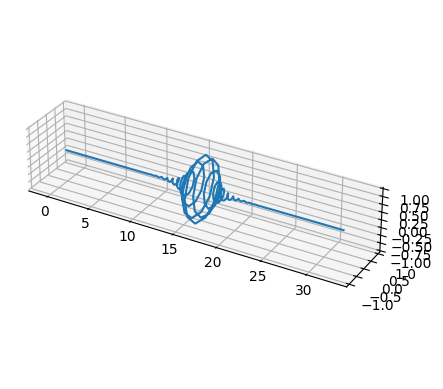

In [93]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(np.linspace(0.0, L, N+1), *nls_out["psi"].dat.data)
ax.set_box_aspect([5.0, 1.0, 1.0])

plt.show()

### Incompressible Navier-Stokes: Energy/Helicity

In [ ]:
# Firedrake-compatible Bessel function
def besselJ(x, alpha, layers=10):
    return sum([
        (-1)**m / math.factorial(m) / special.gamma(m + alpha + 1)
      * (x/2)**(2*m+alpha)
        for m in range(layers)
    ])



# Bessel function parameters
besselJ_root = 5.7634591968945506
besselJ_root_threehalves = besselJ(besselJ_root, 3/2)



# (r, theta, phi) components of Hill vortex
def hill_r(r, theta, radius):
    rho = r / radius
    return 2 * (
        besselJ(besselJ_root*rho, 3/2) / rho**(3/2)
      - besselJ_root_threehalves
    ) * cos(theta)

def hill_theta(r, theta, radius):
    rho = r / radius
    return (
        besselJ_root * besselJ(besselJ_root*rho, 5/2) / rho**(1/2)
      + 2 * besselJ_root_threehalves
      - 2 * besselJ(besselJ_root*rho, 3/2) / rho**(3/2)
    ) * sin(theta)

def hill_phi(r, theta, radius):
    rho = r / radius
    return besselJ_root * (
        besselJ(besselJ_root*rho, 3/2) / rho**(3/2)
      - besselJ_root_threehalves
    ) * rho * sin(theta)



# Hill vortex (Cartesian)
def hill(vec, radius):
    (x, y, z) = vec

    # Cylindrical/spherical coordinates
    r_cyl = sqrt(x**2 + y**2)  # Cylindrical radius
    r_sph = sqrt(x**2 + y**2 + z**2)  # Spherical radius
    theta = conditional(  # Spherical angle
        le(r_cyl, 1e-13),
        0,
        pi/2 - atan(z/r_cyl)
    )

    return conditional(  # If we're outside the vortex...
        ge(r_sph, radius),
        as_vector([0, 0, 0]),
        conditional(  # If we're at the origin...
            le(r_sph, 1e-13),
            as_vector([0, 0, 2*((besselJ_root/2)**(3/2)/special.gamma(5/2) - besselJ_root_threehalves)]),
            conditional(  # If we're on the z axis...
                le(r_cyl, 1e-13),
                as_vector([0, 0, hill_r(r_sph, 0, radius)]),
                as_vector(  # Else...
                    hill_r(r_sph, theta, radius) * np.array([x, y, z]) / r_sph
                  + hill_theta(r_sph, theta, radius) * np.array([x*z, y*z, -r_cyl**2]) / r_sph / r_cyl
                  + hill_phi(r_sph, theta, radius) * np.array([-y, x, 0]) / r_cyl
                )
            )
        )
    )



# Solver
def ns_helicity(
    Re:         Union[int, float] = 2**16,
    N:          int = 8,
    deg:        int = 1,
    time_deg:   int = 1,
    Nt:         int = 48,
    dt:         Union[int, float] = 2**-10,
    output_dir: str = "output/ns_helicity/",
    write_qois: bool = False,
    write_vtk:  bool = False,
) -> Dict[str, List[float]]:
    """
    Energy- and helicity-preserving continuous Petrov-Galerkin Navier-Stokes scheme.

    Returns
    - Dictionary: {"time": [...], "Q1": [...], "Q2": [...]}
    """

    # Ensure output directory exists
    out_path = Path(output_dir)
    out_path.mkdir(parents=True, exist_ok=True)

    # Convert parameters to UFL objects
    Re_c = Constant(Re)
    dt_c = Constant(dt)

    # Mesh and coordinates (periodic box)
    mesh = PeriodicUnitCubeMesh(N, N, N)
    x, y, z = SpatialCoordinate(mesh)

    # Function spaces and functions
    V = VectorFunctionSpace(mesh, "CG", deg + 1)
    Q = FunctionSpace(mesh, "CG", deg)
    R = FunctionSpace(mesh, "R", 0)
    Z = V * Q * R * R * R * V * V * Q * R * R * R  # Mixed space: (u, p, lam_u, utilde, wtilde, theta, lam_w)
    up = Function(Z, name="state")
    u, p, lam_u_0, lam_u_1, lam_u_2, utilde, wtilde, theta, lam_wtilde_0, lam_wtilde_1, lam_wtilde_2 = split(up)
    lam_u = (lam_u_0, lam_u_1, lam_u_2); lam_wtilde = (lam_wtilde_0, lam_wtilde_1, lam_wtilde_2)
    u_out, p_out, lam_u_0_out, lam_u_1_out, lam_u_2_out, utilde_out, wtilde_out, _, _, _, _ = up.subfunctions
    lam_u_out = (lam_u_0_out, lam_u_1_out, lam_u_2_out)
    v, q, mu_v_0, mu_v_1, mu_v_2, vtilde1, vtilde2, eta, mu_vtilde2_0, mu_vtilde2_1, mu_vtilde2_2 = TestFunctions(Z)
    mu_v = (mu_v_0, mu_v_1, mu_v_2); mu_vtilde2 = (mu_vtilde2_0, mu_vtilde2_1, mu_vtilde2_2)

    # (Discretely) div-free projection
    def project_div_free(target):
        Z_ = V * Q * R * R * R
        up_ = Function(Z_)
        u_, p_, lam_u_0_, lam_u_1_, lam_u_2_ = split(up_)
        lam_u_ = (lam_u_0_, lam_u_1_, lam_u_2_)
        v_, q_, mu_v_0_,  mu_v_1_,  mu_v_2_  = TestFunctions(Z_)
        mu_v_ = (mu_v_0_, mu_v_1_, mu_v_2_)
        F_ = (
            inner(u_ - target, v_) * dx
          - inner(p_, div(v_)) * dx
          - sum([inner(lam_u_[i], v_[i]) for i in range(3)]) * dx
          - inner(div(u_), q_) * dx
          - sum([inner(u_[i], mu_v_[i]) for i in range(3)]) * dx
        )
        solve(F_ == 0, up_)
        return up_

    # Initial condition (scaled Hill vortex centred in the box), then div-free projection
    hh = 2 * hill([x - 0.5, y - 0.5, z - 0.5], 0.25)
    print(RED % f"Setting up ICs...")
    up0 = project_div_free(hh)
    u_out.assign(up0.subfunctions[0])
    p_out.assign(up0.subfunctions[1])
    for i in range(3): lam_u_out[i].assign(up0.subfunctions[2+i])
    utilde_out.assign(up0.subfunctions[0])
    wtilde_out.interpolate(curl(hh))

    # Continuous Petrov-Galerkin residual
    dx_time_2     = dx_time(time_deg=2*time_deg)
    dx_time_2plus = dx_time(time_deg=2*time_deg+1)
    dx_time_3     = dx_time(time_deg=3*time_deg)
    F = (
        (  # Momentum
            inner(Dt(u), v) * dx_time_2
          - inner(cross(utilde, wtilde), v) * dx_time_3
          + 1/Re_c * inner(grad(utilde), grad(v)) * dx_time_2
          - inner(p, div(v)) * dx_time_2
          - sum([inner(lam_u[i], v[i]) for i in range(3)]) * dx_time_2
        )
      + (  # Mass
          - inner(div(u), q) * dx_time_2plus
        )
      + (  # Stationary
          - sum([inner(u[i], mu_v[i]) for i in range(3)]) * dx_time_2plus
        )
      + (  # Auxiliary velocity
            inner(utilde, vtilde1) * dx_time_2
          - inner(u, vtilde1) * dx_time_2plus
        )
      + (  # Auxiliary vorticity
            inner(wtilde, vtilde2) * dx_time_2
          - (inner(curl(u), vtilde2) + inner(u, curl(vtilde2))) * dx_time_2plus
          - inner(theta, div(vtilde2)) * dx_time_2
          - sum([inner(lam_wtilde[i], vtilde2[i]) for i in range(3)]) * dx_time_2
        )
      + (  # Auxiliary vorticity incompressibility
          - inner(div(wtilde), eta) * dx_time_2
        )
      + (  # Auxiliary vorticity stationary
          - sum([inner(wtilde[i], mu_vtilde2[i]) for i in range(3)]) * dx_time_2plus
        )
    )

    # Quantities of interest
    Q1 = 0.5 * inner(u, u) * dx  # Energy
    Q2 = 0.5 * inner(u, curl(u)) * dx  # Helicity

    # Time integrator
    t = Constant(0.0)
    stepper = GalerkinTimeStepper(F, time_deg, t, dt_c, up, aux_indices=[1,2,3,4,5,6,7,8,9,10])

    # Set up outputs
    if write_qois:
        qoi_path = out_path / "qois.csv"
        with qoi_path.open("w", encoding="utf-8") as f:
            f.write("time,energy,helicity\n")
        t_arr: List[float] = []
        Q1_arr: List[float] = []
        Q2_arr: List[float] = []

    if write_vtk:
        vtk = VTKFile(str(out_path / "u.pvd"))
        u_out.rename("Velocity (u)")
        vtk.write(u_out, time=float(t))

    def record_and_log():
        t_out = float(t)
        Q1_out = float(assemble(Q1))
        Q2_out = float(assemble(Q2))
        print(BLUE % f"Time (t): {t_out}")
        print(GREEN % f"\tEnergy (Q1):   {Q1_out}")
        print(GREEN % f"\tHelicity (Q2): {Q2_out}")
        if write_qois:
            t_arr.append(t_out)
            Q1_arr.append(Q1_out)
            Q2_arr.append(Q2_out)
            with qoi_path.open("a", encoding="utf-8") as f:
                f.write(f"{t_out},{Q1_out},{Q2_out}\n")

    record_and_log()

    # Time loop
    for _ in range(Nt):
        stepper.advance()
        t.assign(float(t) + float(dt_c))
        if write_vtk: vtk.write(u_out, time=float(t))
        record_and_log()

    # return {"time": t_arr, "energy": Q1_arr, "helicity": Q2_arr}

In [ ]:
ns_helicity(Re=2**0, N=4, deg=1, time_deg=1, Nt=48, dt=2**-16)

firedrake:WARNING Real block detected, generating Schur complement elimination PC


Setting up ICs...


firedrake:WARNING Real block detected, generating Schur complement elimination PC


Time (t): 0.0
	Energy (Q1):   0.8173504053419052
	Helicity (Q2): 12.089860111751891
